# Seawater Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

## Data

In [2]:
Hodell1991 = pd.read_csv('Data/Hodell1991a_supplement.csv')
Hodell1994 = pd.read_csv('Data/Hodell1994a_supplement.csv')
Oslick1994 = pd.read_csv('Data/Oslick1994a_supplement.csv')
Peucker1995 = pd.read_csv('Data/Peucker-Ehrenbrink1995a_supplement.csv')
Ravizza1993 = pd.read_csv('Data/Ravizza1993a_supplement.csv')
Reusch1998 = pd.read_csv('Data/Reusch1998a_supplement.csv')

In [3]:
# ratio to convert from 187Os/186Os to 187Os/188Os
Os_conversion_ratio = 0.12035

Hodell1991_age = Hodell1991['Age [Ma]']
Hodell1991_Sr = Hodell1991['87Sr/86Sr']

Hodell1994_age = Hodell1994['Age [Ma]']
Hodell1994_Sr = Hodell1994['87Sr/86Sr']

Oslick1994_age = Oslick1994['Age_b [Ma]']
Oslick1994_Sr = Oslick1994['87Sr/86Sr']

Peucker1995_age = Peucker1995['Age [ka BP]']/1000
Peucker1995_Os = Peucker1995['187Os/188Os']

Ravizza1993_age = Ravizza1993['Age [ka BP]']/1000
Ravizza1993_Os = Ravizza1993['187Os/186Os'] * Os_conversion_ratio

Reusch1998_age = Reusch1998['Age [Ma]']
Reusch1998_Os = Reusch1998['187Os/188Os']

Ignore the Peucker et al. (1995) data for now, since their leaching procedure produces highly variable results.

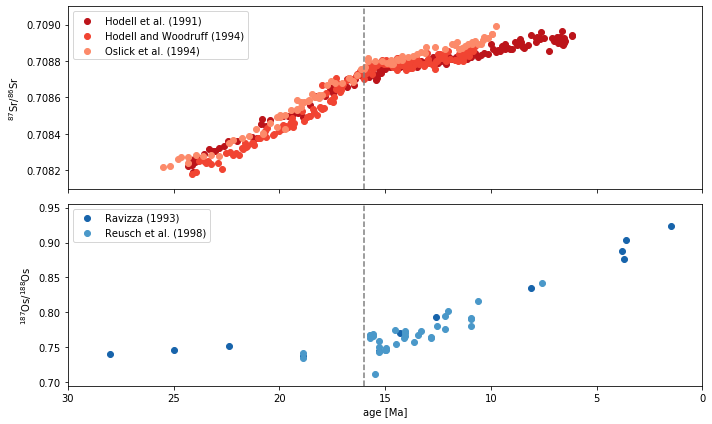

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)

# Sr
Sr_cmap = get_cmap('Reds')

ax[0].scatter(Hodell1991_age, Hodell1991_Sr,
              c=[Sr_cmap(0.8)], label='Hodell et al. (1991)')

ax[0].scatter(Hodell1994_age, Hodell1994_Sr,
              c=[Sr_cmap(0.6)], label='Hodell and Woodruff (1994)')

ax[0].scatter(Oslick1994_age, Oslick1994_Sr,
              c=[Sr_cmap(0.4)], label='Oslick et al. (1994)')

# Os
Os_cmap = get_cmap('Blues')

ax[1].scatter(Ravizza1993_age, Ravizza1993_Os,
              c=[Os_cmap(0.8)], label='Ravizza (1993)')

ax[1].scatter(Reusch1998_age, Reusch1998_Os,
              c=[Os_cmap(0.6)], label='Reusch et al. (1998)')

# prettify
ax[0].axvline(16, ls='--', c='C7')
ax[1].axvline(16, ls='--', c='C7')

ax[0].set_ylim(0.7081, 0.7091)
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].legend()

ax[1].set_ylabel('$^{187}$Os/$^{188}$Os')
ax[1].set_xlabel('age [Ma]')
ax[1].set_xlim(30,0)
ax[1].legend()

fig.tight_layout()
plt.show(fig)

## Seawater Model

In [5]:
def calculate_R(X_F_array, X_R_array, X_R_initial, X_n_t, X_t_step, X_tau):
    """
    Perform the seawater model calculations for element X.
    
    Parameters
    ----------
    X_F_array : array with shape (X_n_t, i)
        Fluxes (mol/yr) - each row represents a time slice, and each column represents a source.
        
    X_R_array : array with shape (X_n_t, i)
        Isotope composition - each row represents a time slice, and each column represents a source.
        
    X_R_initial : float
        Initial isotope composition.
        
    X_n_t : int
        Number of model time steps.
        
    X_t_step : float
        Number of years between model time steps.
        
    X_tau : float
        Residence time of element X (yrs).
        
    Returns
    -------
    X_R_SW : array with shape (X_n_t,)
        Isotope composition of seawater.
    """
    X_R_SW = np.zeros(X_n_t)
    X_R_SW[0] = X_R_initial
    
    for i in range(1, X_n_t):
        X_F_total = np.sum(X_F_array[i,:])
        X_R_sum = np.sum((X_F_array[i,:]/X_F_total) * (X_R_array[i,:] - X_R_SW[i-1]))
        d_X_R = (X_R_sum / X_tau) * X_t_step
        X_R_SW[i] = X_R_SW[i-1] + d_X_R
        
    return X_R_SW

### Myrow et al. (2015)

First, reproduce results from Myrow et al. (2015).

#### Osmium

Model from Myrow et al. (2015):

$$
\frac{dR_{SW}}{dt} = \frac{1}{\tau} \sum_{i} \frac{F_{i}}{F_{tot}}(R_{i} - R_{SW})
$$

Notes:

* Residence time for osmium is from Oxburgh (2001), which estimated a value of 8-10 kyrs.
* Values for invariant sources are taken straight from Myrow et al. (2015)
* Values for the Himalayas are taken straight from Myrow et al. (2015)

In [6]:
# model time : yrs
Os_t_step = 0.01e6
Os_t = np.arange(28e6, 11e6-Os_t_step, -Os_t_step)
Os_n_t = len(Os_t)

# residence time : yrs
Os_tau = 9000

# F : mol/yr
# R : 187Os/188Os

###################
# invariant sources
Os_F_HT_hydrothermal = np.ones(Os_n_t) * 10.5
Os_R_HT_hydrothermal = np.ones(Os_n_t) * 0.26

Os_F_LT_hydrothermal = np.ones(Os_n_t) * 105.1
Os_R_LT_hydrothermal = np.ones(Os_n_t) * 0.11

Os_F_cosmic = np.ones(Os_n_t) * 52.6
Os_R_cosmic = np.ones(Os_n_t) * 0.127

Os_F_eolian = np.ones(Os_n_t) * 36.8
Os_R_eolian = np.ones(Os_n_t) * 1.05

Os_F_rivers = np.ones(Os_n_t) * 1577
Os_R_rivers = np.ones(Os_n_t) * 0.7934
###################

###################
# Himalayan source
Os_amu = 190.23

# F : 28-16 Ma
Os_F_Himalayas_A = np.zeros(len(Os_t[Os_t>16e6]))

# F : 16-11 Ma
Os_F_Himalayas_B_rate = (1.95e-6 * 1000 / Os_amu) * Os_t_step
Os_F_Himalayas_B = np.linspace(0,
                               Os_F_Himalayas_B_rate*(len(Os_t[Os_t<=16e6])-1),
                               len(Os_t[Os_t<=16e6]))

Os_F_Himalayas = np.concatenate([Os_F_Himalayas_A, Os_F_Himalayas_B])

# R : 28-11 Ma
Os_R_Himalayas = np.ones(Os_n_t) * 3.0
###################

# merge into array
Os_sources = ['HT hydrothermal',
              'LT hydrothermal',
              'cosmic',
              'eolian',
              'rivers',
              'Himalayas']
OS_n_sources = len(Os_sources)
Os_F_array = np.stack([Os_F_HT_hydrothermal,
                       Os_F_LT_hydrothermal,
                       Os_F_cosmic,
                       Os_F_eolian,
                       Os_F_rivers,
                       Os_F_Himalayas], axis=1)
Os_R_array = np.stack([Os_R_HT_hydrothermal,
                       Os_R_LT_hydrothermal,
                       Os_R_cosmic,
                       Os_R_eolian,
                       Os_R_rivers,
                       Os_R_Himalayas], axis=1)

# calculate 187Os/188Os evolution
Os_R_SW = calculate_R(Os_F_array, Os_R_array, 0.7356, Os_n_t, Os_t_step, Os_tau)

#### Strontium

Model from Myrow et al. (2015) - it is identical to that used for osmium:

$$
\frac{dR_{SW}}{dt} = \frac{1}{\tau} \sum_{i} \frac{F_{i}}{F_{tot}}(R_{i} - R_{SW})
$$

Notes:

* Residence time for strontium is from Myrow et al. (2015), which estimated a 2-4 million years.
* Values for invariant sources are taken straight from Myrow et al. (2015)
* Values for the Himalayas are taken straight from Myrow et al. (2015)

In [7]:
# model time : yrs
Sr_t_step = 0.01e6
Sr_t = np.arange(23e6, 10e6-Sr_t_step, -Sr_t_step)
Sr_n_t = len(Sr_t)

# residence time : yrs
Sr_tau = 3e6

# F : mol/yr
# R : 187Os/188Os

###################
# invariant sources
Sr_F_diagenetic = np.ones(Sr_n_t) * 3.4e9
Sr_R_diagenetic = np.ones(Sr_n_t) * 0.708

Sr_F_hydrothermal = np.ones(Sr_n_t) * 8.4e9
Sr_R_hydrothermal = np.ones(Sr_n_t) * 0.7025

Sr_F_rivers = np.ones(Sr_n_t) * 31e9
Sr_R_rivers = np.ones(Sr_n_t) * 0.7103
###################

###################
# varying source
Sr_amu = 87.62

# F : 23-16 Ma
Sr_F_Himalayas_A_rate = 1.3e-7 * 1e9 * Sr_t_step
Sr_F_Himalayas_A = np.linspace(0.01e9,
                               0.01e9+Sr_F_Himalayas_A_rate*(len(Sr_t[Sr_t>16e6])-1),
                               len(Sr_t[Sr_t>16e6]))

# F : 16-10 Ma
Sr_F_Himalayas_B_rate = 1.1e-7 * 1e9 * Sr_t_step
Sr_F_Himalayas_B = np.linspace(Sr_F_Himalayas_A[-1],
                               Sr_F_Himalayas_A[-1]+Sr_F_Himalayas_B_rate*(len(Sr_t[Sr_t<=16e6])-1),
                               len(Sr_t[Sr_t<=16e6]))

Sr_F_Himalayas = np.concatenate([Sr_F_Himalayas_A, Sr_F_Himalayas_B])

# R: 23-16 Ma
Sr_R_Himalayas_A_rate = 1.2e-9 * Sr_t_step
Sr_R_Himalayas_A = np.linspace(0.715,
                               0.715+Sr_R_Himalayas_A_rate*(len(Sr_t[Sr_t>16e6])-1),
                               len(Sr_t[Sr_t>16e6]))

# R: 16-10 Ma
Sr_R_Himalayas_B_rate = -0.8e-9 * Sr_t_step
Sr_R_Himalayas_B = np.linspace(Sr_R_Himalayas_A[-1],
                               Sr_R_Himalayas_A[-1]+Sr_R_Himalayas_B_rate*(len(Sr_t[Sr_t<=16e6])-1),
                               len(Sr_t[Sr_t<=16e6]))

Sr_R_Himalayas = np.concatenate([Sr_R_Himalayas_A, Sr_R_Himalayas_B])
###################

# merge into array
Sr_sources = ['diagenetic',
              'hydrothermal',
              'rivers',
              'Himalayas']
Sr_n_sources = len(Sr_sources)
Sr_F_array = np.stack([Sr_F_diagenetic,
                       Sr_F_hydrothermal,
                       Sr_F_rivers,
                       Sr_F_Himalayas], axis=1)
Sr_R_array = np.stack([Sr_R_diagenetic,
                       Sr_R_hydrothermal,
                       Sr_R_rivers,
                       Sr_R_Himalayas], axis=1)

# calculate 87Sr/86Sr evolution
Sr_R_SW = calculate_R(Sr_F_array, Sr_R_array, 0.7082, Sr_n_t, Sr_t_step, Sr_tau)

#### Plot

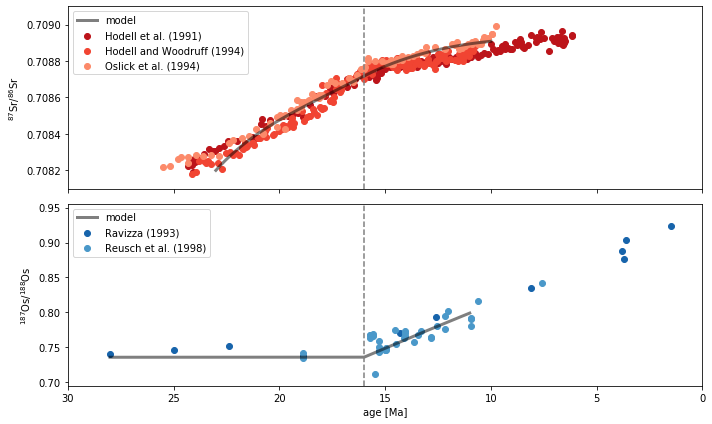

In [8]:
# plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)

# Sr
Sr_cmap = get_cmap('Reds')

ax[0].scatter(Hodell1991_age, Hodell1991_Sr,
              c=[Sr_cmap(0.8)], label='Hodell et al. (1991)')

ax[0].scatter(Hodell1994_age, Hodell1994_Sr,
              c=[Sr_cmap(0.6)], label='Hodell and Woodruff (1994)')

ax[0].scatter(Oslick1994_age, Oslick1994_Sr,
              c=[Sr_cmap(0.4)], label='Oslick et al. (1994)')

ax[0].plot(Sr_t/1e6, Sr_R_SW, c='k', lw=3, alpha=0.5, label='model')

# Os
Os_cmap = get_cmap('Blues')

ax[1].scatter(Ravizza1993_age, Ravizza1993_Os,
              c=[Os_cmap(0.8)], label='Ravizza (1993)')

ax[1].scatter(Reusch1998_age, Reusch1998_Os,
              c=[Os_cmap(0.6)], label='Reusch et al. (1998)')

ax[1].plot(Os_t/1e6, Os_R_SW, c='k', lw=3, alpha=0.5, label='model')

# prettify
ax[0].axvline(16, ls='--', c='C7')
ax[1].axvline(16, ls='--', c='C7')

ax[0].set_ylim(0.7081, 0.7091)
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].legend()

ax[1].set_ylabel('$^{187}$Os/$^{188}$Os')
ax[1].set_xlabel('age [Ma]')
ax[1].set_xlim(30,0)
ax[1].legend()

fig.tight_layout()
plt.show(fig)